In [35]:
import matplotlib.pyplot as plt
import numpy as np
from ase.io import write
from qtpyt.tools import expand_coupling
from ase.build import nanotube
from ase.neighborlist import NeighborList
from qtpyt.base.greenfunction import GreenFunction
from qtpyt.parallel.egrid import GridDesc
from qtpyt.tools import expand_coupling


In [36]:
def build_device_structure(n=6, m=0, N_L=3, N_M=4, N_R=3, bond=1.42, direction='x', tag_regions=True):
    """
    Build a CNT device using ASE nanotube with clear region tagging.

    Args:
        n, m: Chiral indices.
        N_L, N_M, N_R: Unit cells in left, middle, right.
        bond: C–C bond length.
        direction: Axis of tube ('x', 'y', or 'z').
        tag_regions: Whether to tag atoms by region (L=1, M=2, R=3).

    Returns:
        ase.Atoms with 'region' tags if enabled.
    """
    total_cells = N_L + N_M + N_R
    atoms = nanotube(n=n, m=m, length=total_cells, bond=bond, verbose=False)


    if direction == 'x':
        atoms.rotate('z', 'x', rotate_cell=True, center='COP')
        axis = 0
    elif direction == 'y':
        atoms.rotate('z', 'y', rotate_cell=True, center='COP')
        axis = 1
    elif direction == 'z':
        axis = 2
    else:
        raise ValueError("Direction must be 'x', 'y', or 'z'")


    positions = atoms.get_positions()
    coord = positions[:, axis]
    x_min, x_max = coord.min(), coord.max()
    total_len = x_max - x_min
    uc_len = total_len / total_cells


    x_L = x_min + N_L * uc_len
    x_M = x_L + N_M * uc_len

    if tag_regions:
        regions = []
        for x in coord:
            if x < x_L:
                regions.append(1)
            elif x < x_M:
                regions.append(2)
            else:
                regions.append(3)
        atoms.set_array('region', np.array(regions, dtype=int))

    atoms.set_pbc((1, 0, 0))
    return atoms

def apply_strain(atoms, strain_percent, axis=0, copy=True):
    """
    Apply uniaxial strain only to region 2 (middle) of the CNT structure,
    anchoring the left boundary and shifting region 3 to preserve bond lengths.

    Parameters
    ----------
    atoms : ase.Atoms
        Atomic structure with a 'region' array.
    strain_percent : float
        Strain percentage to apply to region 2.
    axis : int
        Axis along which to apply strain (default: 0 for x-axis).
    copy : bool
        If True (default), operates on a copy of `atoms`. If False, modifies `atoms` in-place.

    Returns
    -------
    ase.Atoms
        Strained ASE Atoms object.

    Notes
    -----
    Region 2 is stretched from its left boundary.
    Region 3 is rigidly shifted to maintain M–R bond lengths.
    Region 1 is left unmodified.
    """
    if copy:
        atoms = atoms.copy()

    if 'region' not in atoms.arrays:
        raise ValueError("Atoms object must have 'region' array to apply region-specific strain.")

    positions = atoms.get_positions()
    regions = atoms.get_array('region')

    strain = 1 + strain_percent / 100.0
    print(f"Applying {strain_percent}% strain to region 2 (middle) along axis {axis}.")
    coord = positions[:, axis]
    mask_M = regions == 2
    mask_R = regions == 3


    x_M_min = coord[mask_M].min()
    x_M_max = coord[mask_M].max()
    original_length = x_M_max - x_M_min


    strained_positions = positions.copy()
    strained_positions[mask_M, axis] = x_M_min + strain * (positions[mask_M, axis] - x_M_min)


    delta = (strain - 1.0) * original_length
    print(f"Shifting region 3 by {delta:.4f} along axis {axis}.")
    strained_positions[mask_R, axis] += delta

    atoms.set_positions(strained_positions)
    return atoms


def build_real_space_device_hamiltonian(atoms, pairs, bond=1.42, beta=0.0, t0=-2.7):

    """Construct real-space Hamiltonian for a CNT device using known neighbor pairs.

    Args:
        atoms (ase.Atoms): CNT device structure.
        pairs (List[Tuple[int, int, Tuple[int, int, int]]]): Precomputed nearest-neighbor pairs.
        bond (float): Ideal bond length.
        beta (float): Decay factor for hopping integral.
        t0 (float): Hopping at ideal bond length.
        atol (float): Absolute tolerance for bond length deviation.

    Returns:
        np.ndarray: Hamiltonian matrix (shape: N_atoms x N_atoms).
    """

    N_atoms = len(atoms)
    positions = atoms.get_positions()
    cell = atoms.get_cell()
    H = np.zeros((N_atoms, N_atoms), dtype=float)

    for i, j, offset in pairs:
        ri = positions[i]
        rj = positions[j] + np.dot(offset, cell)
        dist = np.linalg.norm(ri - rj)
        hopping = t0 * np.exp(-beta * (dist / bond - 1))
        H[i, j] = hopping
        H[j, i] = hopping

    return H

def get_nearest_neighbor_pairs(atoms, neighbor_cutoff=1.43, bond=1.42, atol=0.1):
    """
    Compute nearest-neighbor atom pairs using a distance cutoff and bond tolerance.

    Args:
        atoms (ase.Atoms): The atomic structure.
        neighbor_cutoff (float): Distance threshold for neighbors.
        bond (float): Ideal bond length.
        atol (float): Absolute tolerance for bond length deviation.

    Returns:
        List[Tuple[int, int, Tuple[int, int, int]]]: Valid neighbor pairs and cell offsets.
    """
    N = len(atoms)
    cutoffs = [neighbor_cutoff] * N
    nl = NeighborList(cutoffs, self_interaction=False, bothways=True)
    nl.update(atoms)

    positions = atoms.get_positions()
    cell = atoms.get_cell()

    pairs = set()
    for i in range(N):
        for j, offset in zip(*nl.get_neighbors(i)):
            if j > i:
                ri = positions[i]
                rj = positions[j] + np.dot(offset, cell)
                dist = np.linalg.norm(ri - rj)
                if np.abs(dist - bond) <= atol:
                    pairs.add((i, j, tuple(offset)))
    return list(pairs)

In [37]:
# Parameters
n, m = 6, 0
ncells = 2
bond = 1.42
onsite = 0.0  # eV
first_neighbor_hopping = -2.7  # eV
beta = 0.0
neighbor_cutoff = 1.43  # Å for nearest neighbors
d0 = bond
self_energy = np.load('lead_self_energy.npy',allow_pickle=True)

In [5]:
device = build_device_structure(n=6, m=0, N_L=1, N_M=4, N_R=1, direction='x')
pairs = get_nearest_neighbor_pairs(device, neighbor_cutoff=neighbor_cutoff)


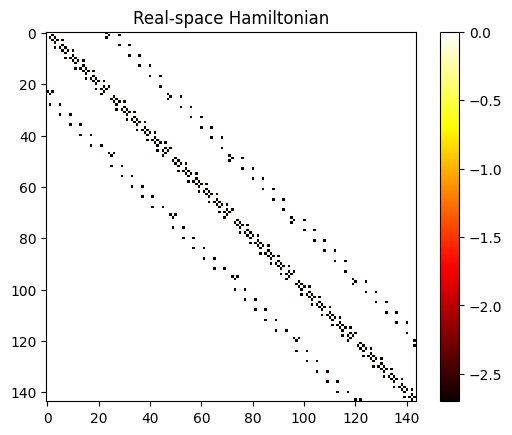

In [6]:
H_device= build_real_space_device_hamiltonian(device, pairs, bond=bond, beta=beta, t0=first_neighbor_hopping)
S_device = np.eye(H_device.shape[0])
plt.imshow(H_device, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Real-space Hamiltonian')
plt.show()


In [7]:
expand_coupling(self_energy[0], len(H_device[0]))
expand_coupling(self_energy[1], len(H_device[0]), id='right')

eta = 1e-5

# slice(None) means that we've already expanded the leads to the scattering region
gf = GreenFunction(H_device, S_device, selfenergies=[(slice(None),self_energy[0]),(slice(None),self_energy[1])], eta=eta)

energies = np.linspace(-3, 3, 100)
gd = GridDesc(energies, 1)
T = np.empty(gd.energies.size)

for e, energy in enumerate(gd.energies):
    T[e] = gf.get_transmission(energy, ferretti=False)

T = gd.gather_energies(T)

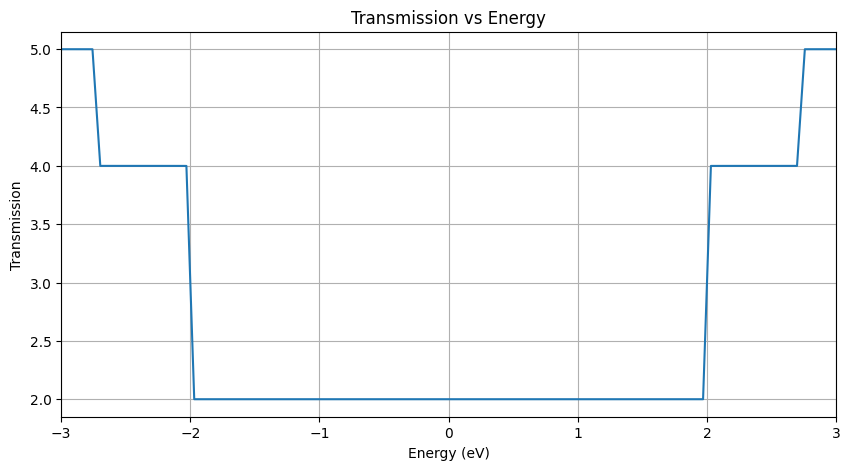

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(energies, T)
plt.xlabel("Energy (eV)")
plt.ylabel("Transmission")
plt.title("Transmission vs Energy")
plt.xlim(-3, 3)
# plt.ylim(0, 1)
plt.grid()
plt.show()


### Strained

Applying 4.0% strain to region 2 (middle) along axis 0.
Shifting region 3 by 0.1420 along axis 0.


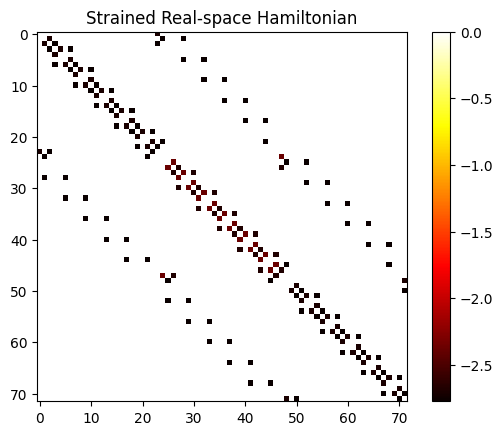

In [38]:
beta = 3.1451 # Value from WannierTools, https://pubs.acs.org/doi/10.1021/acs.nanolett.9b05117
strained_device = apply_strain(device, 4.0, axis=0)
H_strained_device = build_real_space_device_hamiltonian(strained_device, pairs, bond=bond, beta=beta, t0=first_neighbor_hopping)
S_strained_device = np.eye(H_strained_device.shape[0])
plt.imshow(H_strained_device, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Strained Real-space Hamiltonian')
plt.show()

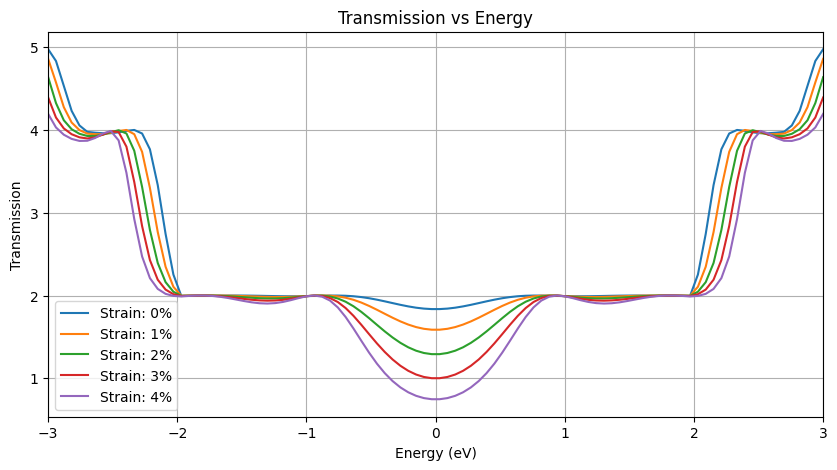

In [13]:
strain_percentages = np.array([0, 1, 2, 3, 4])
plt.figure(figsize=(10, 5))
for strain in strain_percentages:
    strained_device = apply_strain(device, strain, axis=0)
    H_strained_device = build_real_space_device_hamiltonian(strained_device, pairs, bond=bond, beta=beta, t0=first_neighbor_hopping)
    S_strained_device = np.eye(H_strained_device.shape[0])

    gf = GreenFunction(H_strained_device, S_strained_device, selfenergies=[(slice(None),self_energy[0]),(slice(None),self_energy[1])], eta=eta)

    gd = GridDesc(energies, 1)
    T = np.empty(gd.energies.size)

    for e, energy in enumerate(gd.energies):
        T[e] = gf.get_transmission(energy, ferretti=False)

    T = gd.gather_energies(T)
    plt.plot(energies, T, label=f"Strain: {strain}%")
plt.xlabel("Energy (eV)")
plt.ylabel("Transmission")
plt.title("Transmission vs Energy")
plt.xlim(-3, 3)
# plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.show()

### Increase number of unit cell that are strained

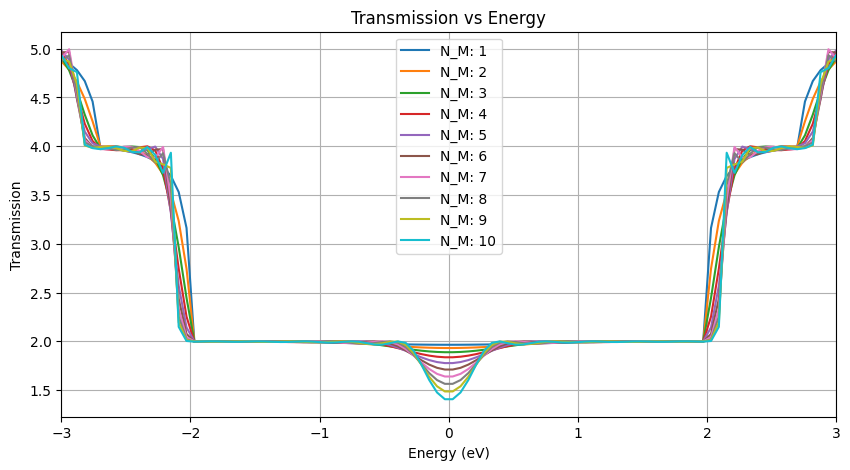

In [41]:
N_Ms = [1, 2, 3, 4, 5,6,7,8,9,10]
plt.figure(figsize=(10, 5))

for N_M in N_Ms:
    device = build_device_structure(n=6, m=0, N_L=1, N_M=N_M, N_R=1, direction='x')
    pairs = get_nearest_neighbor_pairs(device, neighbor_cutoff=neighbor_cutoff)

    H_device = build_real_space_device_hamiltonian(device, pairs, bond=bond, beta=beta, t0=first_neighbor_hopping)
    S_device = np.eye(H_device.shape[0])

    self_energy = np.load('lead_self_energy.npy',allow_pickle=True)

    expand_coupling(self_energy[0], len(H_device[0]))
    expand_coupling(self_energy[1], len(H_device[0]), id='right')

    gf = GreenFunction(H_device, S_device, selfenergies=[(slice(None),self_energy[0]),(slice(None),self_energy[1])], eta=eta)

    gd = GridDesc(energies, 1)
    T = np.empty(gd.energies.size)

    for e, energy in enumerate(gd.energies):
        T[e] = gf.get_transmission(energy, ferretti=False)

    T = gd.gather_energies(T)
    plt.plot(energies, T, label=f"N_M: {N_M}")

plt.xlabel("Energy (eV)")
plt.ylabel("Transmission")
plt.title("Transmission vs Energy")
plt.xlim(-3, 3)
# plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.show()

Applying 4.0% strain to region 2 (middle) along axis 0.
Shifting region 3 by 0.3124 along axis 0.
Applying 4.0% strain to region 2 (middle) along axis 0.
Shifting region 3 by 0.6532 along axis 0.
Applying 4.0% strain to region 2 (middle) along axis 0.
Shifting region 3 by 0.9940 along axis 0.
Applying 4.0% strain to region 2 (middle) along axis 0.
Shifting region 3 by 1.3348 along axis 0.
Applying 4.0% strain to region 2 (middle) along axis 0.
Shifting region 3 by 1.6756 along axis 0.


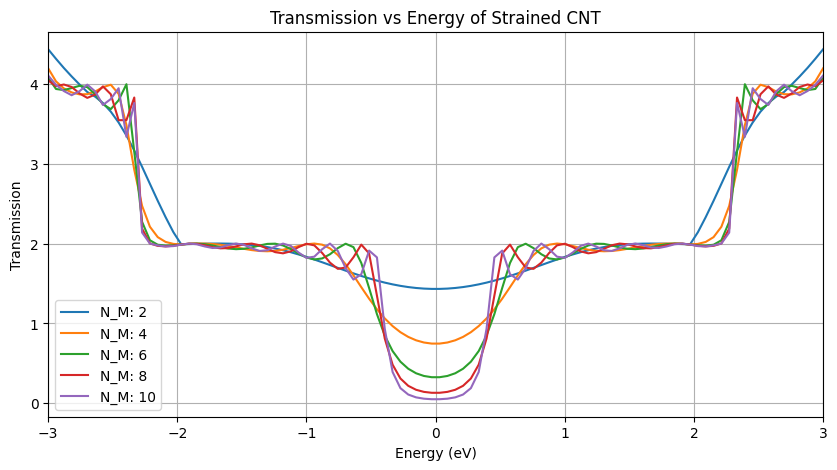

In [46]:
N_Ms = [2, 4, 6, 8 ,10]
strain = 4.0
plt.figure(figsize=(10, 5))

for N_M in N_Ms:
    device = build_device_structure(n=6, m=0, N_L=1, N_M=N_M, N_R=1, direction='x')
    pairs = get_nearest_neighbor_pairs(device, neighbor_cutoff=neighbor_cutoff)

    strained_device = apply_strain(device, strain, axis=0)
    H_strained_device = build_real_space_device_hamiltonian(strained_device, pairs, bond=bond, beta=beta, t0=first_neighbor_hopping)
    S_strained_device = np.eye(H_strained_device.shape[0])

    self_energy = np.load('lead_self_energy.npy',allow_pickle=True)
    expand_coupling(self_energy[0], len(H_strained_device[0]))
    expand_coupling(self_energy[1], len(H_strained_device[0]), id='right')

    gf = GreenFunction(H_strained_device, S_strained_device, selfenergies=[(slice(None),self_energy[0]),(slice(None),self_energy[1])], eta=eta)


    gd = GridDesc(energies, 1)
    T = np.empty(gd.energies.size)

    for e, energy in enumerate(gd.energies):
        T[e] = gf.get_transmission(energy, ferretti=False)

    T = gd.gather_energies(T)
    plt.plot(energies, T, label=f"N_M: {N_M}")

plt.xlabel("Energy (eV)")
plt.ylabel("Transmission")
plt.title("Transmission vs Energy of Strained CNT")
plt.xlim(-3, 3)
# plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.show()